**Identify IR Excess White Dwarfs**

In [ ]:
from astropy.io import fits
from astropy.table import Table, join, unique, vstack, hstack
import pyphot
from pyphot import unit

# imports for extinction correction
from astropy.coordinates import SkyCoord
import astropy.units as u
from dustmaps.edenhofer2023 import Edenhofer2023Query
import extinction

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from pyvo import registry  # version >=1.4.1 
from astroquery.gaia import Gaia
import corv

plt.style.use('stefan.mplstyle')

In [2]:
# read the cross-matched WISE & Gentile-Fusillo+21 (I think) sources
catalog = Table.read('data/1710105466553A.csv')

In [3]:
# get bailer-jones distances for each target
stardats = []
row_lims = 2000 # row limit for astroquery

iters = (len(catalog) + 2000) // 2000 # split the table into batches to run in sequence
for i in tqdm(range(iters)): # Note: there's got to be a better way to do this, but setting the Gaia.ROW_LIMIT doesn't seem to work??
        ADQL_CODE1 = """SELECT dist.source_id, dist.r_med_geo
        FROM gaiadr3.gaia_source as gaia
        JOIN external.gaiaedr3_distance as dist
        ON gaia.source_id = dist.source_id      
        WHERE gaia.source_id in {}""".format(tuple(catalog['GaiaEDR3'][2000*i:2000*i+2000]))
        stardats.append(Gaia.launch_job(ADQL_CODE1,dump_to_file=False).get_results()) # append the table to stardats
gaia_d1 = vstack(stardats) # squash the list of tables into one complete distance table

catalog.rename_column('GaiaEDR3', 'source_id')
catalog = join(catalog, gaia_d1, keys = 'source_id') # join the main catalog with the bailer-jones distances

100%|██████████| 115/115 [03:16<00:00,  1.71s/it]


In [4]:
catalog = catalog[catalog['r_med_geo'] < 200] # filter out stars that are very far away

In [5]:
# convert the provided WISE fluxes into usable units
lib = pyphot.get_library()
f = [lib['WISE_RSR_W1'], lib['WISE_RSR_W2']] # define the WISE filters

# signal-to-noise ratio is flux over error
catalog['w1snr'] = catalog['FW1'] / catalog['e_FW1'];
catalog['w2snr'] = catalog['FW2'] / catalog['e_FW2'];

# first, convert from Jansky to flam according to https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html, then convert flam to Vega magnitudes
catalog['w1mpro'] = -2.5 * np.log10(2.99792458e-5 * 309.05e-9 * catalog['FW1'] / f[0].lpivot.to('angstrom').value**2) - f[0].Vega_zero_mag
catalog['w2mpro'] = -2.5 * np.log10(2.99792458e-5 * 167.66e-9 * catalog['FW2'] / f[1].lpivot.to('angstrom').value**2) - f[1].Vega_zero_mag

# calculate magnitude uncertainties
catalog['w1sigm'] = catalog['e_FW1'] / (1.09 * catalog['FW1'])
catalog['w2sigm'] = catalog['e_FW2'] / (1.09 * catalog['FW2'])

/tmp/ipykernel_1407091/3888285872.py:6: RuntimeWarning: invalid value encountered in divide
  catalog['w1snr'] = catalog['FW1'] / catalog['e_FW1'];
/tmp/ipykernel_1407091/3888285872.py:7: RuntimeWarning: invalid value encountered in divide
  catalog['w2snr'] = catalog['FW2'] / catalog['e_FW2'];
/tmp/ipykernel_1407091/3888285872.py:10: RuntimeWarning: divide by zero encountered in log10
  catalog['w1mpro'] = -2.5 * np.log10(2.99792458e-5 * 309.05e-9 * catalog['FW1'] / f[0].lpivot.to('angstrom').value**2) - f[0].Vega_zero_mag
/tmp/ipykernel_1407091/3888285872.py:11: RuntimeWarning: divide by zero encountered in log10
  catalog['w2mpro'] = -2.5 * np.log10(2.99792458e-5 * 167.66e-9 * catalog['FW2'] / f[1].lpivot.to('angstrom').value**2) - f[1].Vega_zero_mag
/tmp/ipykernel_1407091/3888285872.py:14: RuntimeWarning: invalid value encountered in divide
  catalog['w1sigm'] = catalog['e_FW1'] / (1.09 * catalog['FW1'])
/tmp/ipykernel_1407091/3888285872.py:15: RuntimeWarning: invalid value encount

In [6]:
# quality filter the dataset (flag explanation: https://catalog.unwise.me/files/unwise_bitmask_writeup-03Dec2018.pdf)

mask = np.all([catalog['w1snr'] > 3, catalog['w2snr'] > 3, # only select rows with W1 & W2 SNR > 3
               catalog['FlagsW1'] == 0, catalog['FlagsW2'] == 0], # discard rows with flags indicating crowded field, diffraction spikes, etc
               axis=0)
catalog = catalog[mask] # apply the filter

Apply de-reddening.

In [9]:
from __future__ import print_function

# create a new column in catalog containing the skycoord object for each star using the bailer-jones distances
coords = [SkyCoord(frame="icrs", ra=catalog['RAdeg'][i]*u.deg, dec=catalog['DEdeg'][i]*u.deg, distance = catalog['r_med_geo'][i] * u.pc) for i in range(len(catalog))]
catalog['wd_coords'] = coords

# query Edenhofer2023 to get E(B-V) in arbitrary units
bsq = Edenhofer2023Query() # instantiate the Edenhofer query
bsq_res = bsq.query(catalog['wd_coords']).copy()
bsq_res[np.isnan(bsq_res)] = 0 # don't correct any rows with failed queries

Optimizing map for querying (this might take a couple of seconds)...


: 

In [ ]:
# convert to actual units (todo: check the dustmaps docs)
Ebv = bsq_res*0.901*0.98 # i don't totally remember the details of why this is necessary
catalog['E(B-V)'] = Ebv
catalog['e_E(B-V)'] = Ebv*0.2

# Parameters for correcting using Gaia
Rv = 3.1
catalog['A_v0'] = catalog['E(B-V)']*Rv

# fetch Gaia photometric band pivot wavelengths and store in `gaia_phot_wavl`
lib = pyphot.get_library()
gaia_filters = [lib['Gaia_G'], lib['Gaia_BP'], lib['Gaia_RP'], lib['WISE_RSR_W1'], lib['WISE_RSR_W2']]
gaia_phot_wavl = np.array([filter.lpivot.to('angstrom').value for filter in gaia_filters])

# for each point, find extinction using the parameters we defined above
ext_all = []
for av0 in catalog['A_v0']:
    ext_all.append( extinction.fitzpatrick99(gaia_phot_wavl, av0, Rv) )
ext_all = np.array(ext_all)
    
# save the extinction in each band
catalog['G_ext'] = ext_all.T[0]
catalog['BP_ext'] = ext_all.T[1]
catalog['RP_ext'] = ext_all.T[2]
catalog['W1_ext'] = ext_all.T[3]
catalog['W2_ext'] = ext_all.T[4]

# subtract out the extinction to find de-reddened magnitude
catalog['GAIA_G'] = catalog['Gmag'] - catalog['G_ext']
catalog['GAIA_BP'] = catalog['BPmag'] - catalog['BP_ext']
catalog['GAIA_RP'] = catalog['RPmag'] - catalog['RP_ext']
catalog['WISE_W1'] = catalog['w1mpro'] - catalog['W1_ext']
catalog['WISE_W2'] = catalog['w2mpro'] - catalog['W2_ext']

In [10]:
# save absolute magnitudes and useful colors into the table for easy access later
abs_mag = lambda row: catalog['row'] - 5 * np.log10(catalog['r_med_geo']) + 5

catalog['abs_g'] = abs_mag('GAIA_G')
catalog['abs_bp'] = abs_mag('GAIA_BP')
catalog['abs_rp'] = abs_mag('GAIA_RP')
catalog['abs_w1'] = abs_mag('WISE_W1')
catalog['abs_w2'] = abs_mag('WISE_W2')

catalog['bp_rp'] = catalog['abs_bp'] - catalog['abs_rp']

Text(0, 0.5, 'G-W2, mag')

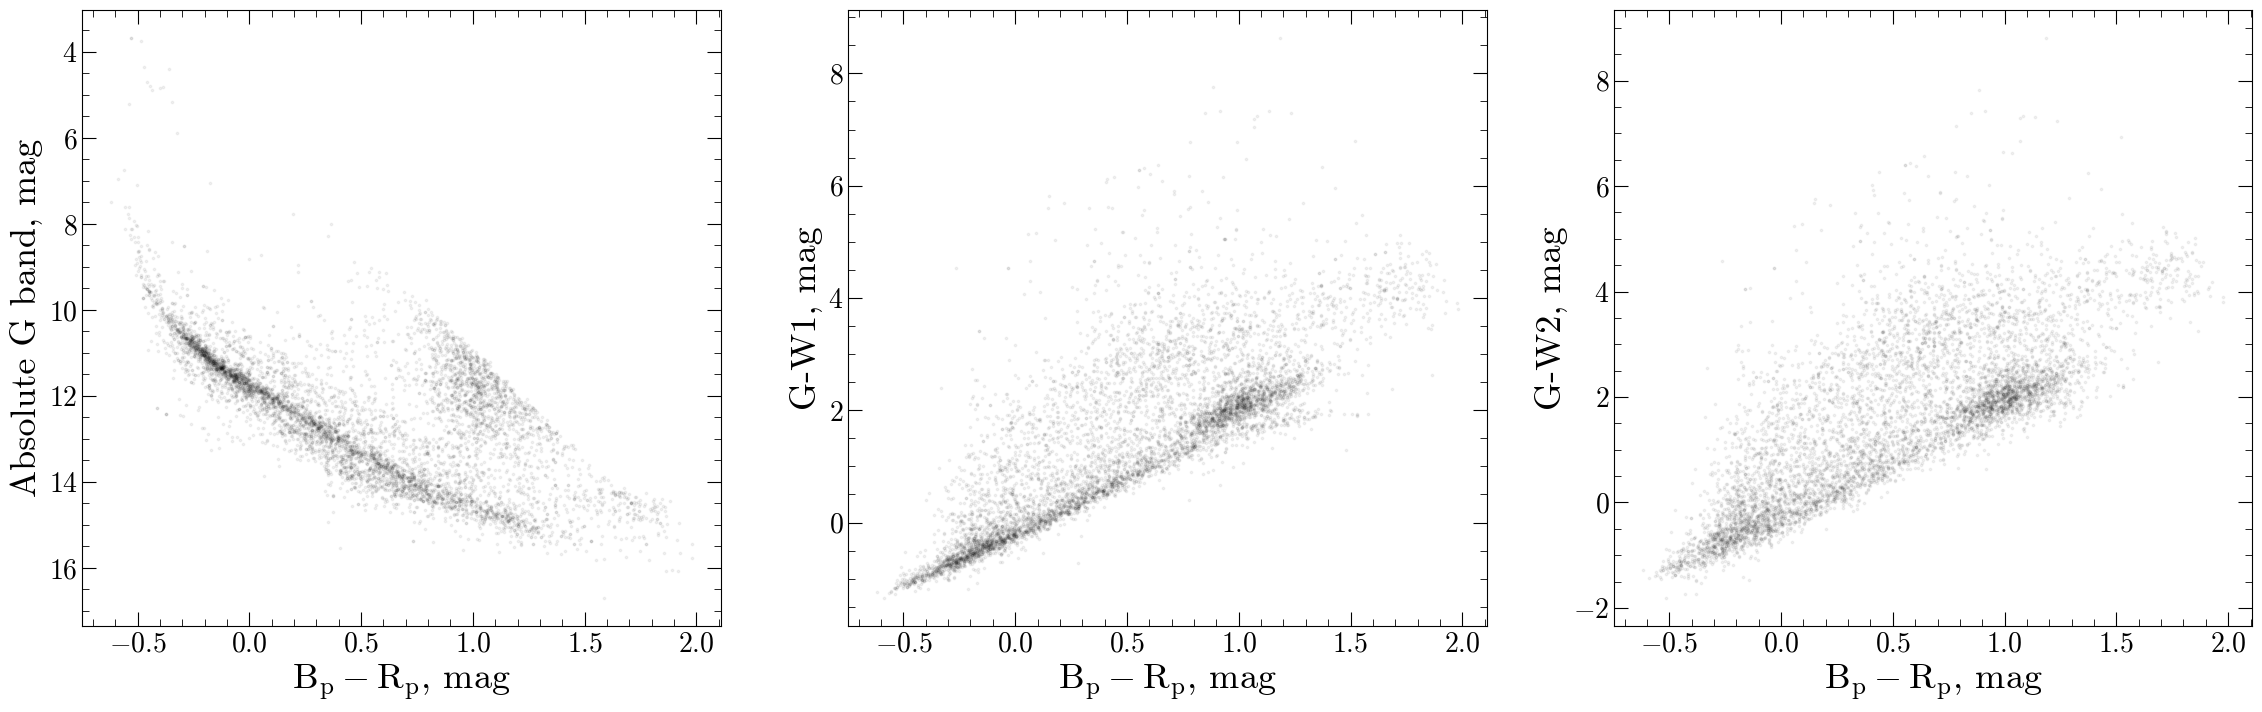

In [11]:
# sanity plots

plt.figure(figsize=(28,8))

plt.subplot(1,3,1) # color-magnitude diagram
plt.scatter(catalog['bp_rp'], catalog['abs_g'], s = 3, c = 'k', alpha = 0.05)
plt.xlabel('$B_p-R_p$, mag')
plt.ylabel('Absolute G band, mag')
plt.gca().invert_yaxis()

plt.subplot(1,3,2) # color-color diagram for bp-rp vs. g-W1
plt.scatter(catalog['bp_rp'], catalog['abs_g'] - catalog['abs_w1'], s = 3, c = 'k', alpha = 0.05)
plt.xlabel('$B_p-R_p$, mag')
plt.ylabel('G-W1, mag')

plt.subplot(1,3,3) # color-color diagram for bp-rp vs. g-W2
plt.scatter(catalog['bp_rp'], catalog['abs_g'] - catalog['abs_w2'], s = 3, c = 'k', alpha = 0.05)
plt.xlabel('$B_p-R_p$, mag')
plt.ylabel('G-W2, mag')

In [12]:
from pyphot import unit

base_wavl, tremblay, table = corv.utils.build_montreal_da(path = '/home/sarsene1/corv/src/corv/models/montreal_da', flux_unit = 'flam')

bp_rp = []
rp_w1 = []
rp_w2 = []

lib = pyphot.get_library()
filters = [lib['Gaia_G'], lib['Gaia_BP'], lib['Gaia_RP'], lib['WISE_RSR_W1'], lib['WISE_RSR_W2']]

logg = 8
teffs = np.linspace(5000, 120000, 500)

for i in tqdm(range(len(teffs))):
    spec = tremblay((teffs[i], logg))
    
    fluxes = [filters[j].get_flux(base_wavl * unit['angstrom'], spec* unit['erg/s/cm**2/angstrom'], axis=1).to('erg/s/cm**2/angstrom').value for j in range(len(filters))]
    mags = [-2.5 * np.log10(fluxes[j]) - filters[j].Vega_zero_mag for j in range(len(filters))]
    
    bp_rp.append(mags[1] - mags[2])
    rp_w1.append(mags[2] - mags[3])
    rp_w2.append(mags[2] - mags[4])
    
bp_rp = list(reversed(bp_rp))
rp_w1 = list(reversed(rp_w1))
rp_w2 = list(reversed(rp_w2))

catalog['w1_diffs'] = (catalog['abs_rp'] - catalog['abs_w1']) - np.interp(catalog['bp_rp'], bp_rp, rp_w1)
catalog['w2_diffs'] = (catalog['abs_rp'] - catalog['abs_w2']) - np.interp(catalog['bp_rp'], bp_rp, rp_w2)

building montreal da model
could not find pickled WD models
/Users/vedantchandra/0_research/01_sdss5/006_build_corv/data/comm_cat/
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


100%|██████████| 500/500 [00:29<00:00, 16.70it/s]


In [13]:
catalog = catalog[~np.isinf(catalog['w1_diffs'])]
catalog = catalog[~np.isinf(catalog['w2_diffs'])]

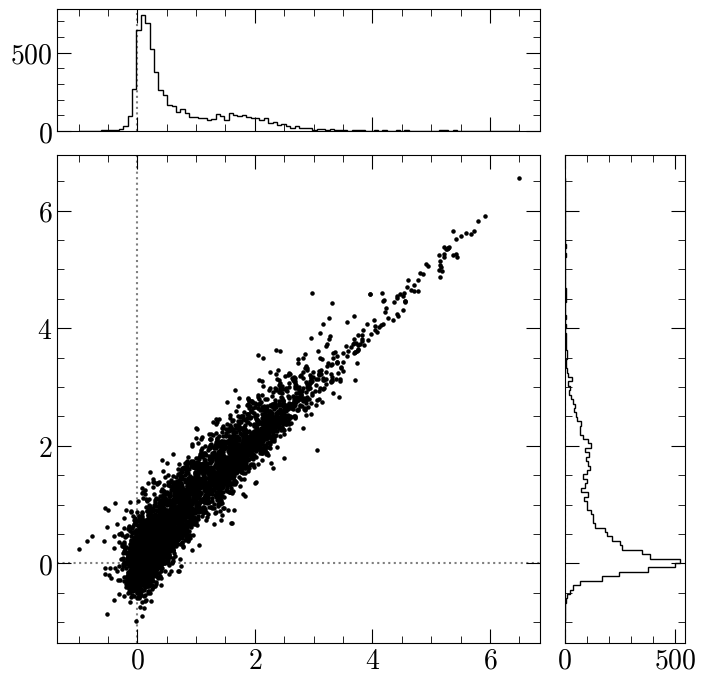

In [14]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, c = 'k', s = 5)
    ax.axhline(y = 0, ls = ':', alpha = 0.5, c = 'k')
    ax.axvline(x = 0, ls = ':', alpha = 0.5, c = 'k')

    # now determine nice limits by hand:
    binwidth = 0.25
    #xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    #lim = (int(xymax/binwidth) + 1) * binwidth

    #bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=100, color = 'k', histtype = 'step')
    ax_histx.axvline(x = 0, ls = ':', alpha = 0.5, c = 'k')
    ax_histy.hist(y, bins=100, orientation='horizontal', color = 'k', histtype = 'step')
    ax_histy.axvline(x = 0, ls = ':', alpha = 0.5, c = 'k')

fig = plt.figure(layout='constrained')

ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
ax.set(aspect=1)

ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)

scatter_hist(catalog['w1_diffs'], catalog['w2_diffs'], ax, ax_histx, ax_histy)

plt.show()

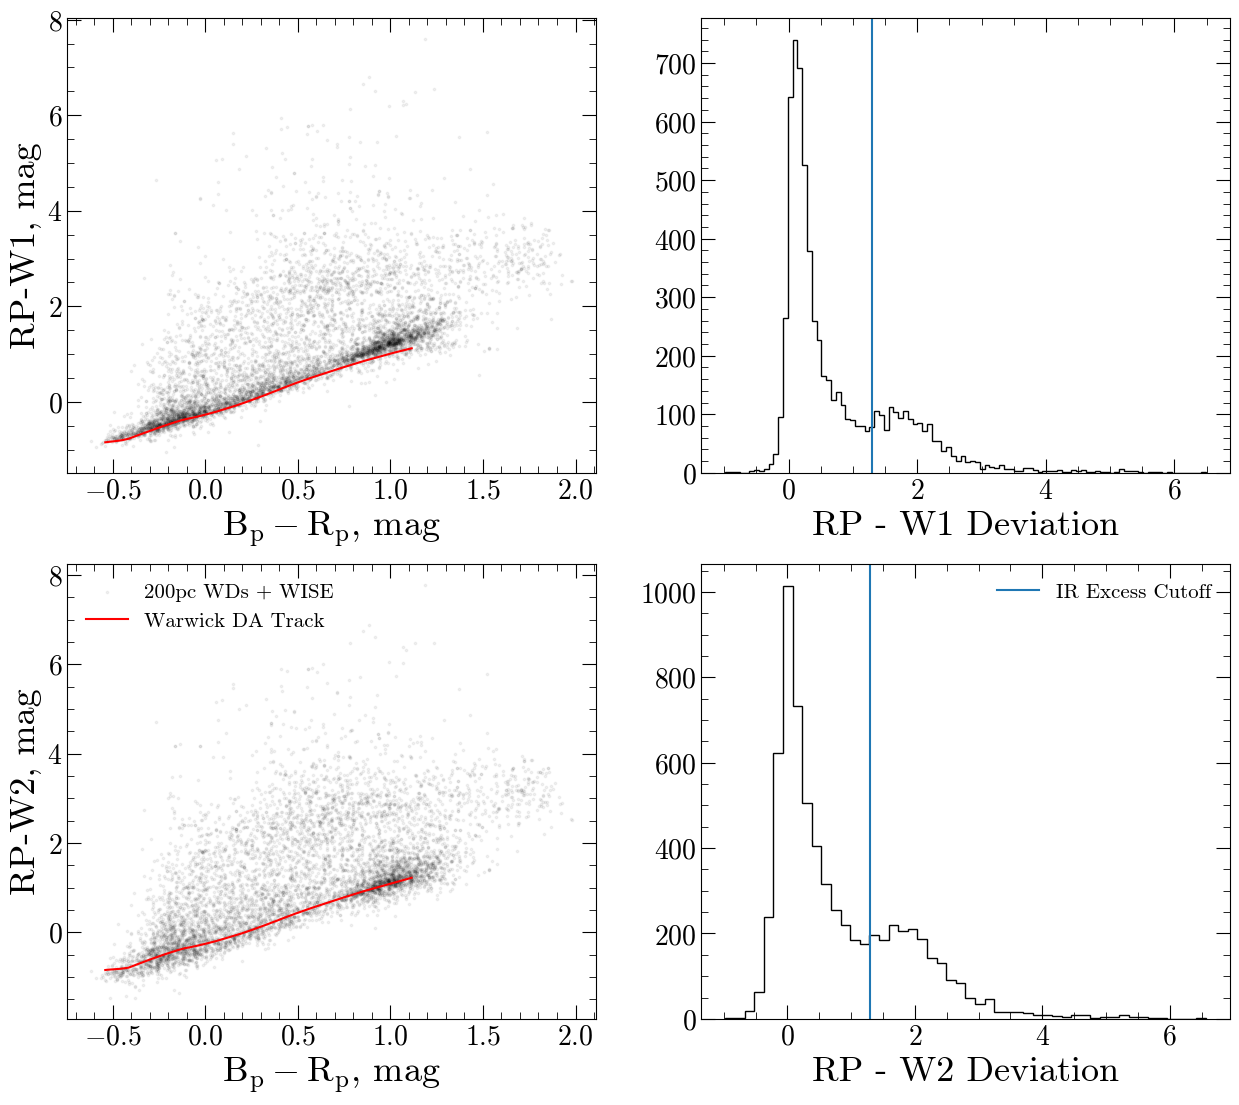

In [15]:
plt.figure(figsize=(15,13))

plt.subplot(2,2,1)

plt.scatter(catalog['bp_rp'], catalog['abs_rp'] - catalog['abs_w1'], s = 3, c = 'k', alpha = 0.05)
plt.plot(bp_rp, rp_w1, c='red', label='Warwick DA Track')

plt.xlabel('$B_p-R_p$, mag')
plt.ylabel('RP-W1, mag')

plt.subplot(2,2,2)

plt.hist(catalog[~np.isinf(catalog['w1_diffs'])]['w1_diffs'], color = 'k', histtype = 'step', bins = 100)
plt.axvline(x = 1.3)

plt.xlabel('RP - W1 Deviation')

plt.subplot(2,2,3)

plt.scatter(catalog['bp_rp'], catalog['abs_rp'] - catalog['abs_w2'], s = 3, c = 'k', alpha = 0.05, label = '200pc WDs + WISE')
plt.plot(bp_rp, rp_w2, c='red', label='Warwick DA Track')

plt.xlabel('$B_p-R_p$, mag')
plt.ylabel('RP-W2, mag')
plt.legend(framealpha=0)

plt.subplot(2,2,4)

plt.hist(catalog[~np.isinf(catalog['w2_diffs'])]['w2_diffs'], color = 'k', histtype = 'step', bins = 50)
plt.axvline(x = 1.3, label = 'IR Excess Cutoff')

plt.xlabel('RP - W2 Deviation')
plt.legend(framealpha=0)

#plt.savefig('ir_excess.png')

In [16]:
w1_mask = np.all([~np.isinf(catalog['w1_diffs']), catalog['w1_diffs'] > 1.3], axis = 0)
w2_mask = np.all([~np.isinf(catalog['w2_diffs']), catalog['w2_diffs'] > 1.3], axis = 0)

mask = np.any([w1_mask, w2_mask], axis=0)

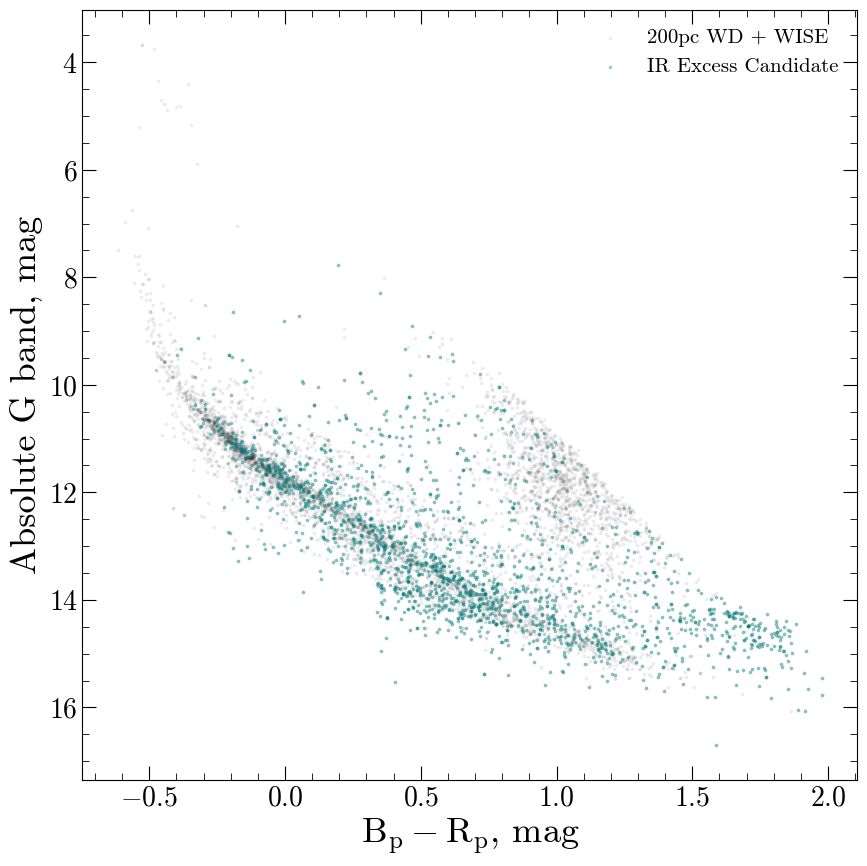

In [17]:
plt.figure(figsize=(10,10))


plt.scatter(catalog['bp_rp'], catalog['abs_g'], s = 3, c = 'k', alpha = 0.05, label = '200pc WD + WISE')
plt.scatter(catalog[mask]['bp_rp'], catalog[mask]['abs_g'], s = 3, c = 'teal', alpha = 0.3, label = 'IR Excess Candidate')


plt.xlabel('$B_p-R_p$, mag')
plt.ylabel('Absolute G band, mag')

plt.legend(framealpha=0)

plt.gca().invert_yaxis()

In [18]:
len(catalog[mask])

1974

Text(0.5, 0, 'G - W2 Deviation')

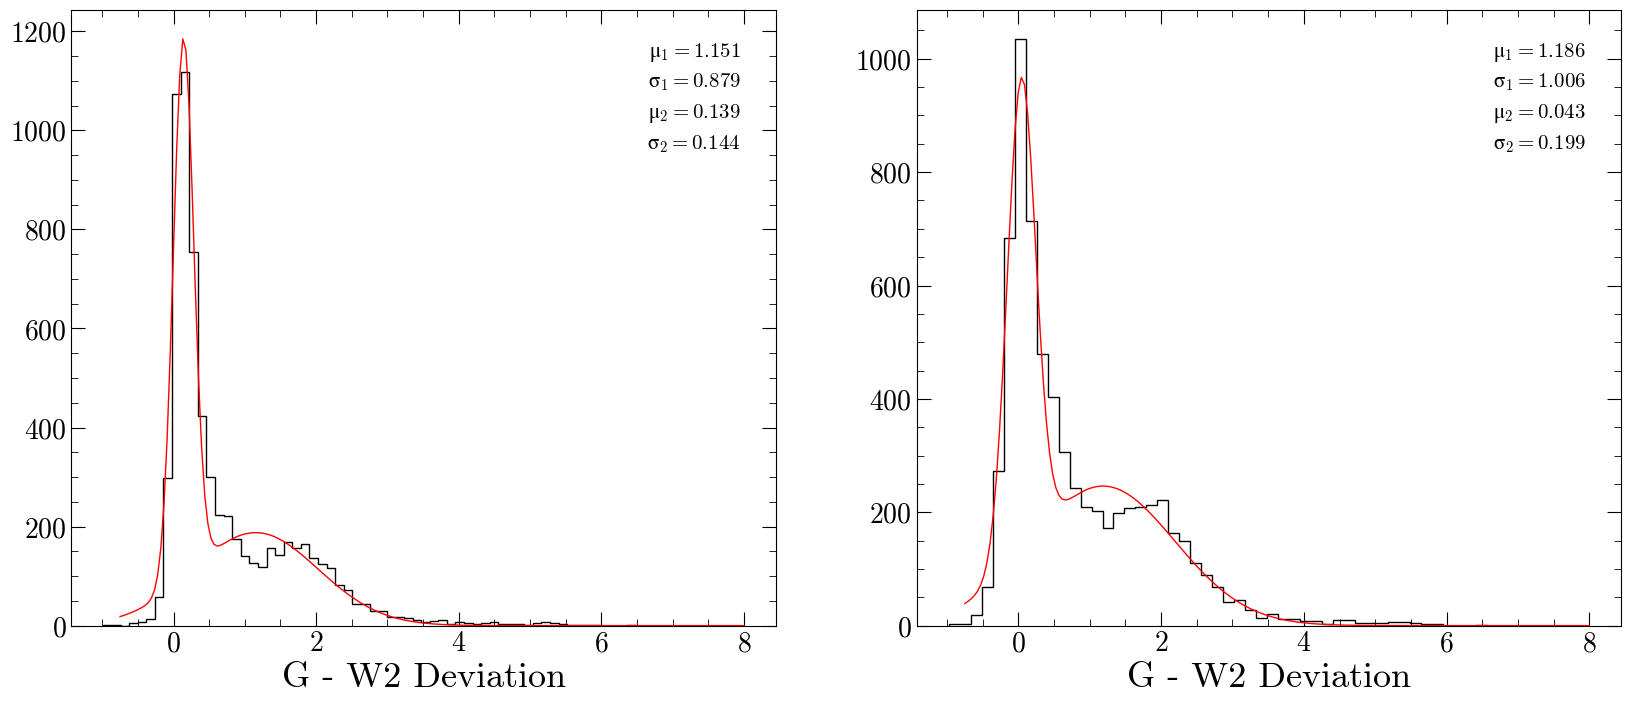

In [19]:
from scipy.optimize import leastsq

fitfunc  = lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/p[2])**2) + p[3]*np.exp(-0.5*((x-p[4])/p[5])**2)
errfunc  = lambda p, x, y: (y - fitfunc(p, x))

init  = [10.0, 0.5, 5, 10.0, 0.5, 5]
domain = np.linspace(-0.75,8,200)

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)

n, bins, patches = plt.hist(catalog[~np.isinf(catalog['w1_diffs'])]['w1_diffs'], color = 'k', histtype='step')

x = [np.mean([bins[i], bins[i+1]]) for i in range(len(bins) - 1)]
init  = [20.0, 0.5, 5, 20.0, 4, 5]

out   = leastsq( errfunc, init, args=(x, n))
c = out[0]

plt.plot(domain, fitfunc(c, domain), c='r', linewidth = 1)

plt.text(0.95, 0.95, r'$\mu_1 = %.3f$' % c[1] ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)
plt.text(0.95, 0.9, r'$\sigma_1 = %.3f$' % np.average( np.abs(c[2]) ) ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)
plt.text(0.95, 0.85, r'$\mu_2 = %.3f$' % c[4] ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)
plt.text(0.95, 0.8, r'$\sigma_2 = %.3f$' % np.average( np.abs(c[5]) ) ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)

plt.xlabel('G - W2 Deviation')

plt.subplot(1,2,2)

n, bins, patches = plt.hist(catalog[~np.isinf(catalog['w2_diffs'])]['w2_diffs'], color = 'k', histtype='step')

x = [np.mean([bins[i], bins[i+1]]) for i in range(len(bins) - 1)]
init  = [20.0, 0.5, 5, 20.0, 0.5, 5]

out   = leastsq( errfunc, init, args=(x, n))
c = out[0]

plt.plot(domain, fitfunc(c, domain), c='r', linewidth = 1)

plt.text(0.95, 0.95, r'$\mu_1 = %.3f$' % c[1] ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)
plt.text(0.95, 0.9, r'$\sigma_1 = %.3f$' % np.average( np.abs(c[2]) ) ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)
plt.text(0.95, 0.85, r'$\mu_2 = %.3f$' % c[4] ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)
plt.text(0.95, 0.8, r'$\sigma_2 = %.3f$' % np.average( np.abs(c[5]) ) ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)

plt.xlabel('G - W2 Deviation')

In [20]:
w1_mask

array([False, False,  True, ..., False, False, False])

In [21]:
catalog['w1_excess_flag'] = np.zeros(len(catalog))
catalog['w2_excess_flag'] = np.zeros(len(catalog))

for i in tqdm(range(len(catalog))):
    if w1_mask[i] == True:
        catalog['w1_excess_flag'][i] = 1
    if w2_mask[i] == True:
        catalog['w2_excess_flag'][i] = 1

100%|██████████| 6688/6688 [00:00<00:00, 303979.21it/s]


In [22]:
catalog.write('data/possible_ir_excess.fits', overwrite=True)